In [25]:
# -*- coding: utf-8 -*-

"""
Created January 29, 2023
"""

import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


DATA_DIR = (
    "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns"
)
BOX_CSV = "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns/image_box_agg.csv"
IMAGE_CSV = "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns/image_box_agg.csv"
DICOM_METADATA_PATH = "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/results_bias/data/dicom_metadata_df.pkl"
VARIABLES_OF_INTEREST = [
    "(0008, 0070) Manufacturer",
    "(0008, 1090) Manufacturer's Model Name",
    "(0012, 0030) Clinical Trial Site ID",
    "(0018, 1000) Device Serial Number",
]
RANDOM_STATE = 33


In [3]:
boxes = pd.read_csv(os.path.join(DATA_DIR, "boxes.csv"))
image_boxes = pd.read_csv(os.path.join(DATA_DIR, "image_box_agg.csv"))


In [4]:
df_boxes = boxes.merge(image_boxes, on="image", how="inner").drop(
    columns=["path_x", "path_y", "Unnamed: 0_x", "Unnamed: 0_y"]
)

df_boxes["join_id"] = df_boxes["image"].astype("int64")

df_boxes


,image,percent_total_area,horizontal_side,vertical_side,area_sum,area_sum_without_edges,n_boxes,join_id
0,3769001,1.008949,edge,edge,1.008949,0.000000,1,3769001
1,615703,1.008949,edge,edge,1.008949,0.000000,1,615703
2,3791802,1.008949,edge,edge,1.008949,0.000000,1,3791802
3,1638304,1.008949,edge,edge,1.008949,0.000000,1,1638304
4,2612401,1.008949,edge,edge,1.008949,0.000000,2,2612401
...,...,...,...,...,...,...,...,...
44263,3515401,0.001016,indeterminate,indeterminate,0.001016,0.001016,1,3515401
44264,3815302,0.001016,indeterminate,bottom,0.001016,0.001016,1,3815302
44265,3972401,0.001016,left,indeterminate,0.001016,0.001016,1,3972401
44266,3223704,0.001016,right,top,0.001016,0.001016,1,3223704


In [23]:
with open(DICOM_METADATA_PATH, "rb") as f:
    dicom_metadata = pickle.load(f)


def merge_metadata(target_variable):
    df_dicom_metadata = dicom_metadata.copy()
    df_dicom_metadata["join_id"] = dicom_metadata.index.values.astype("int64")
    df_dicom_metadata = df_dicom_metadata[["join_id", target_variable]]

    df = df_boxes.merge(df_dicom_metadata, on="join_id", how="inner").drop(
        columns=["join_id", "image"]
    )

    df = df.dropna(subset=[target_variable])

    return df


def is_categorical(c, test_type=np.float64):
    try:
        return not (np.issubdtype(c, np.float64) or np.issubdtype(c, np.int64))
    except:
        return True


def preprocess_data(target_variable):
    df = merge_metadata(target_variable)
    y = df[target_variable]
    xt = df.drop([target_variable], axis=1)

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    categorical_features = xt.columns[xt.dtypes.apply(lambda c: is_categorical(c))]
    numeric_features = xt.columns[xt.dtypes.apply(lambda c: not is_categorical(c))]
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        verbose_feature_names_out=True,
    )

    preprocessor.fit(xt)

    feature_names = []
    for name, transformer, features in preprocessor.get_params()["transformers"]:
        try:
            feature_names += (
                preprocessor.named_transformers_[name].get_feature_names_out().tolist()
            )
        except AttributeError:
            feature_names += features.tolist()

    return preprocessor.transform(xt), y, feature_names


def get_model_metrics(target_variable, model=SGDClassifier, **params):
    model_xt, y, _ = preprocess_data(target_variable)

    X_train, X_test, y_train, y_test = train_test_split(
        model_xt, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )

    clf = model(**params).fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)

    return {
        "accuracy": metrics.accuracy_score(y_train, y_train_pred),
        "model": clf,
    }


def get_model_params(target_variable):
    model_xt, y, _ = preprocess_data(target_variable)

    X_train, X_test, y_train, y_test = train_test_split(
        model_xt, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )

    grid = GridSearchCV(
        SGDClassifier(max_iter=1000),
        param_grid={
            # "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
            # "alpha": [0.0001, 0.001, 0.01, 0.1],
            #   "penalty": ["l2", "l1", "elasticnet", "none"],
            "loss": ["hinge"],
            "penalty": ["l1", "l2"],
        },
        verbose=1,
        cv=3,
    ).fit(X_train, y_train)

    return grid.best_params_


In [20]:
warnings.filterwarnings("ignore")

for var in VARIABLES_OF_INTEREST:
    params = get_model_params(var)
    model_metrics = get_model_metrics(var, **params)

    print(f"Variable: {var} with a model accuracy of {model_metrics['accuracy']}")


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Variable: (0008, 0070) Manufacturer with a model accuracy of 0.4352137432427951
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Variable: (0008, 1090) Manufacturer's Model Name with a model accuracy of 0.44755587213961356
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Variable: (0012, 0030) Clinical Trial Site ID with a model accuracy of 0.2296470446393586
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Variable: (0018, 1000) Device Serial Number with a model accuracy of 0.6657325860688551


# Serial Number Prediction

Similar accuracy numbers are obtained with logistic regression.

In [24]:
get_model_metrics(VARIABLES_OF_INTEREST[3], LogisticRegression)


{'accuracy': 0.6697357886309048, 'model': LogisticRegression()}

## Serial Model Counts

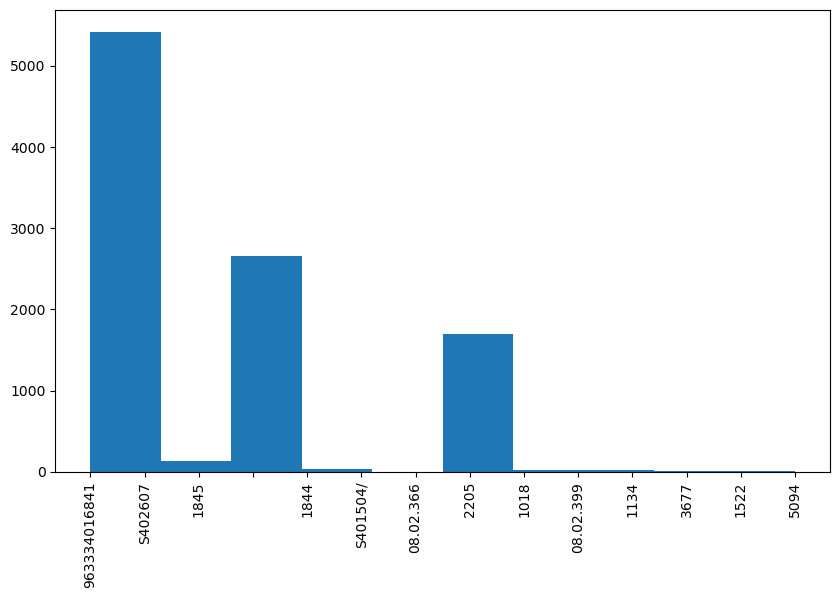

In [10]:
serial_number = VARIABLES_OF_INTEREST[3]

plt.figure(figsize=(10, 6))
plt.hist(merge_metadata(serial_number)[serial_number])
plt.xticks(rotation=90)
plt.show()


In [11]:
model_xt, y, features = preprocess_data(serial_number)

X_train, X_test, y_train, y_test = train_test_split(
    model_xt, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

model = SGDClassifier(loss="hinge", penalty="l1").fit(X_train, y_train)

results = permutation_importance(
    model, X_train, y_train, random_state=RANDOM_STATE, n_jobs=-1
)


Feature: percent_total_area, Score: 0.003122497998398677
Feature: area_sum, Score: 0.18374699759807842
Feature: area_sum_without_edges, Score: 0.08636242327195083
Feature: n_boxes, Score: 0.006431812116359703
Feature: horizontal_side_edge, Score: -2.2204460492503132e-17
Feature: horizontal_side_indeterminate, Score: 0.016946890846010088
Feature: horizontal_side_left, Score: 0.03426741393114485
Feature: horizontal_side_right, Score: 0.0362690152121697
Feature: vertical_side_bottom, Score: 0.029303442754203313
Feature: vertical_side_edge, Score: 0.018548171870829955
Feature: vertical_side_indeterminate, Score: 0.018121163597544655
Feature: vertical_side_top, Score: 0.006992260475046641


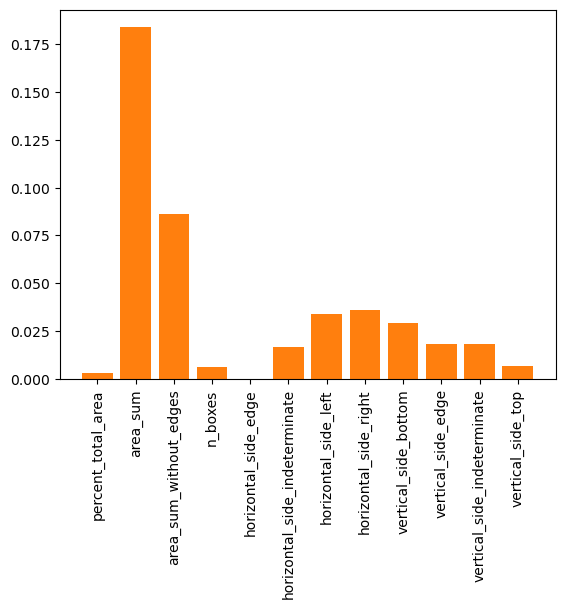

In [17]:
for i, v in enumerate(results.importances_mean):
    print(f"Feature: {features[i]}, Score: {v}")
    plt.bar(features, results.importances_mean)

plt.xticks(rotation=90)
plt.show()


## Serial Numbers

There is a bit of a class imbalance issue with the largest number of serial numbers being `9633..`.  The most important feature in classifcation according to permutation importance is the area sum followed by the area sum without a corresponding edge. 

